In [5]:
# ============================================================
# Employee Attrition Project - Notebook 03
# 03_feature_engineering_and_shap.ipynb
# Purpose:
#   - Load processed train/test data from Notebook 2
#   - Perform optional feature engineering
#   - Train baseline RandomForest model
#   - Build SHAP-ready explainability pipeline
# ============================================================

# -------------------------
# 1. Imports
# -------------------------
import os
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
import joblib
import shap


In [6]:
# -------------------------
# 2. Set Paths (Works on Mac, Windows, Linux)
# -------------------------
import os
from pathlib import Path

# Universal path detection - works on all systems
project_root = Path.cwd()

if project_root.name == "notebooks":
    project_root = project_root.parent

processed_folder = project_root / "data" / "processed"
models_folder = project_root / "models"
models_folder.mkdir(exist_ok=True)

train_path = str(processed_folder / "train.csv")
test_path = str(processed_folder / "test.csv")
y_train_path = str(processed_folder / "y_train.csv")
y_test_path = str(processed_folder / "y_test.csv")

print(f"Project root: {project_root}")
print(f"Processed folder: {processed_folder}")
print(f"\nChecking if files exist:")
print(f"  train.csv: {Path(train_path).exists()}")
print(f"  test.csv: {Path(test_path).exists()}")
print(f"  y_train.csv: {Path(y_train_path).exists()}")
print(f"  y_test.csv: {Path(y_test_path).exists()}")

Project root: /Users/benjaminnguyen/Employee_attrition
Processed folder: /Users/benjaminnguyen/Employee_attrition/data/processed

Checking if files exist:
  train.csv: True
  test.csv: True
  y_train.csv: True
  y_test.csv: True


In [7]:
# -------------------------
# 3. Load Processed Data
# -------------------------
X_train = pd.read_csv(train_path)
X_test = pd.read_csv(test_path)
y_train = pd.read_csv(y_train_path).squeeze()
y_test = pd.read_csv(y_test_path).squeeze()

print(f"Train shape: {X_train.shape}, Test shape: {X_test.shape}")
print(f"Target distribution (train):\n{y_train.value_counts(normalize=True)}")

Train shape: (1176, 55), Test shape: (294, 55)
Target distribution (train):
Attrition
0    0.838435
1    0.161565
Name: proportion, dtype: float64


RECURSIVE FEATURE ELIMINATION (RFE)

Fitting RFE... This may take a minute...
Fitting estimator with 55 features.
Fitting estimator with 54 features.
Fitting estimator with 53 features.
Fitting estimator with 52 features.
Fitting estimator with 51 features.
Fitting estimator with 50 features.
Fitting estimator with 49 features.
Fitting estimator with 48 features.
Fitting estimator with 47 features.
Fitting estimator with 46 features.
Fitting estimator with 45 features.
Fitting estimator with 44 features.
Fitting estimator with 43 features.
Fitting estimator with 42 features.
Fitting estimator with 41 features.
Fitting estimator with 40 features.
Fitting estimator with 39 features.
Fitting estimator with 38 features.
Fitting estimator with 37 features.
Fitting estimator with 36 features.
Fitting estimator with 35 features.
Fitting estimator with 34 features.
Fitting estimator with 33 features.
Fitting estimator with 32 features.
Fitting estimator with 31 features.
Fitting estimator with

/var/folders/6h/7mzzcq9s2n9bzh_kl09v6t780000gn/T/ipykernel_85816/1514821217.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=top_30, y='feature', x='ranking', palette=colors)


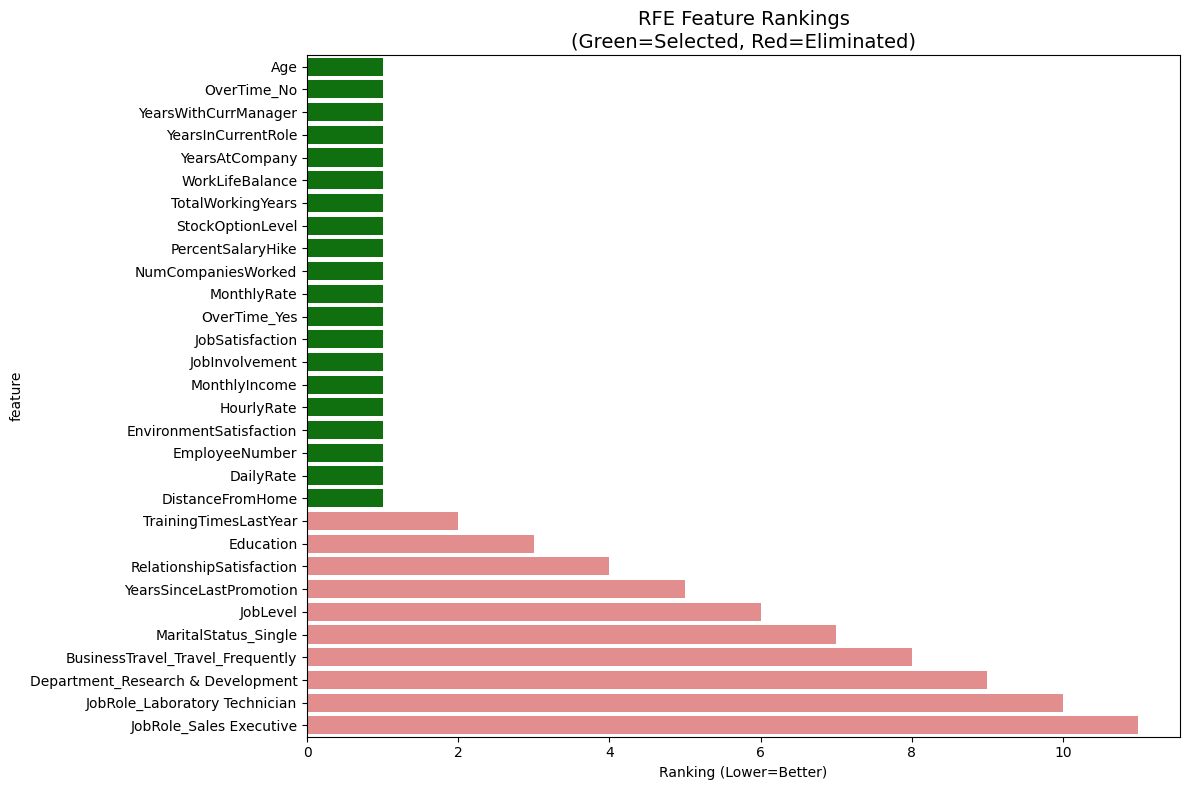


✓ RFE analysis complete!
Selected 20 features for modeling


In [8]:
# -------------------------
# 3.5. RECURSIVE FEATURE ELIMINATION (RFE)
# -------------------------
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import seaborn as sns

print("="*70)
print("RECURSIVE FEATURE ELIMINATION (RFE)")
print("="*70)

# Create RFE selector
rfe_estimator = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    random_state=42,
    n_jobs=-1
)

rfe_selector = RFE(
    estimator=rfe_estimator,
    n_features_to_select=20,
    step=1,
    verbose=1
)

print("\nFitting RFE... This may take a minute...")
rfe_selector.fit(X_train, y_train)

# Get selected features
rfe_selected_features = X_train.columns[rfe_selector.support_].tolist()

# Create ranking DataFrame
rfe_rankings = pd.DataFrame({
    'feature': X_train.columns,
    'ranking': rfe_selector.ranking_,
    'selected': rfe_selector.support_
}).sort_values('ranking')

print(f"\n✓ RFE Complete!")
print(f"\nRFE Selected {len(rfe_selected_features)} features:")
print(rfe_rankings[rfe_rankings['selected'] == True][['feature', 'ranking']])

# Visualize
plt.figure(figsize=(12, 8))
top_30 = rfe_rankings.head(30)
colors = ['green' if x else 'lightcoral' for x in top_30['selected']]
sns.barplot(data=top_30, y='feature', x='ranking', palette=colors)
plt.title('RFE Feature Rankings\n(Green=Selected, Red=Eliminated)', fontsize=14)
plt.xlabel('Ranking (Lower=Better)')
plt.tight_layout()
plt.show()

print(f"\n✓ RFE analysis complete!")
print(f"Selected {len(rfe_selected_features)} features for modeling")

In [9]:
# -------------------------
# 4. Optional Feature Engineering
# -------------------------
if "YearsAtCompany" in X_train.columns and "JobLevel" in X_train.columns:
    X_train["Tenure_per_Level"] = X_train["YearsAtCompany"] / (X_train["JobLevel"] + 1)
    X_test["Tenure_per_Level"] = X_test["YearsAtCompany"] / (X_test["JobLevel"] + 1)

print("Feature engineering complete.")

Feature engineering complete.


In [10]:
# -------------------------
# 5. Train Baseline Model
# -------------------------
model = RandomForestClassifier(
    n_estimators=200,
    random_state=42,
    class_weight="balanced"
)
model.fit(X_train, y_train)
print("Model training complete.")

Model training complete.


In [11]:
# -------------------------
# 6. Save Model
# -------------------------
model_path = os.path.join(models_folder, "employee_attrition_rf.pkl")
joblib.dump(model, model_path)
print(f"Model saved to: {model_path}")

Model saved to: /Users/benjaminnguyen/Employee_attrition/models/employee_attrition_rf.pkl


In [12]:
# -------------------------
# 7. SHAP Explainability Setup
# -------------------------
shap.initjs()
explainer = shap.TreeExplainer(model)

print("Computing SHAP values (this may take a moment)...")
shap_values = explainer.shap_values(X_test)

Computing SHAP values (this may take a moment)...


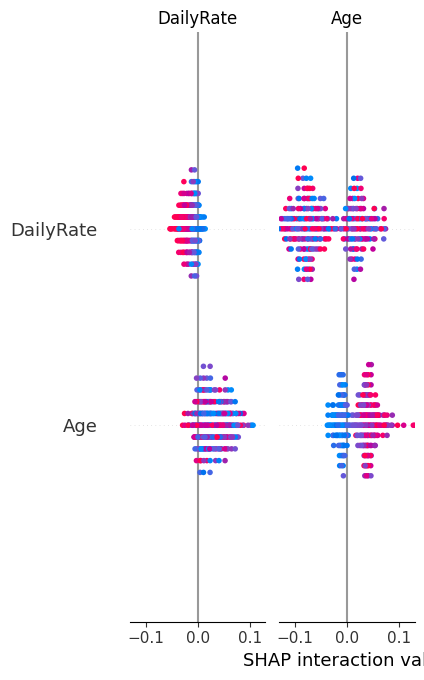

In [13]:
# -------------------------
# 8. SHAP Global Feature Importance
# -------------------------
if isinstance(shap_values, list):
    sv = shap_values[1]  # class 1 (Attrition=Yes)
else:
    sv = shap_values
shap.summary_plot(sv, X_test, plot_type="bar")

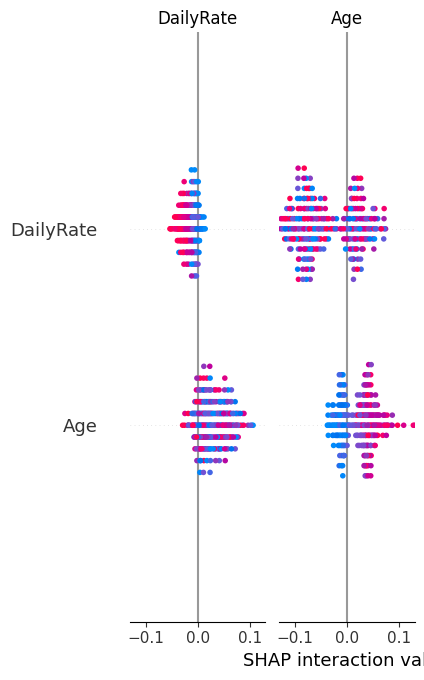

In [14]:

# -------------------------
# 9. SHAP Detailed Summary Plot
# -------------------------
shap.summary_plot(sv, X_test)